In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from utils import sample_batch, display

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

2023-07-18 21:17:08.713596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 21:17:08.818187: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 21:17:08.845984: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-18 21:17:09.279527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


2023-07-18 21:17:09.999385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 21:17:10.024799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 21:17:10.024987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 21:17:10.025678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

### Parameters 

In [2]:
IMAGE_SIZE = 64 
CHANNELS = 3 
BATCH_SIZE = 128 
NUM_FEATURES = 64 
Z_DIM = 200 
LEARNING_RATE = 0.0005
EPOCHS = 10 
BETA = 2000
LOAD_MODEL = False 

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "../data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [4]:
#preprocess the data 
def preprocess(img):
    img = tf.cast(img,"float32") / 255.0
    return img 

train = train_data.map(lambda x: preprocess(x))

In [5]:
train_sample = sample_batch(train)

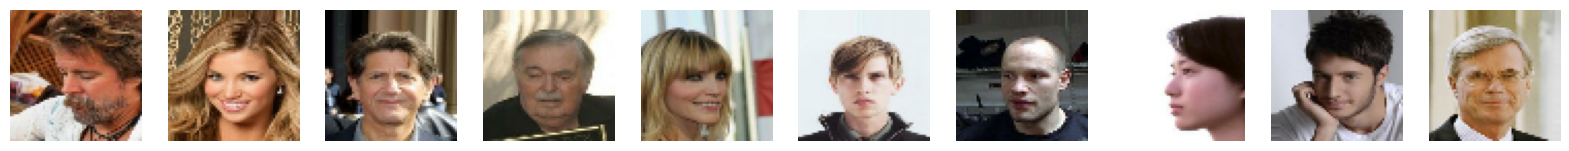

In [6]:
#show some faces from the training set 
display(train_sample, cmap=None)

### Build the variational autoencoder 

In [7]:
class Sampling(layers.Layer):
    def call(self,inputs):
        z_mean,z_log_var = inputs 
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
#Encoder 

encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:] # stored later for decoder 
    
x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z],name="encoder")
encoder.summary()
    

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]

In [9]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         36928     
 nspose)                                                     

In [10]:
class VAE(models.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder 
        self.decoder = decoder 
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def call(self,inputs):
        z_mean,z_log_var,z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean,z_log_var,reconstruction 
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data,training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data,reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 
                    * (1+z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss 
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss" : self.reconstruction_loss_tracker.result(),
            "kl_loss" : self.kl_loss_tracker.result()
        }
    
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
#create a variational autoencoder
vae = VAE(encoder, decoder)

### Train the variational autoencoder

In [12]:
#compile the variational autoencoder 
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [13]:
#Create a model save checkpoint 
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = "./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode="min",
    save_best_only = True,
    verbose= 0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img 
        self.latent_dim = latent_dim
        
    def on_epoch_end(self,epoch,logs= None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim))
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255 
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))
    

In [14]:
#load old weights if required 
if LOAD_MODEL: 
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1)) 
    

In [15]:
vae.fit(
    train,
    epochs= EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim = Z_DIM),
    ],
)

Epoch 1/10


2023-07-18 21:17:18.138997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-07-18 21:17:19.146372: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1583/1583 [==============================] - ETA: 0s - loss: 101.8396 - reconstruction_loss: 68.7092 - kl_loss: 15.4715

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 73s 44ms/step - loss: 101.8285 - reconstruction_loss: 68.7092 - kl_loss: 15.4715
Epoch 2/10
1582/1583 [============================>.] - ETA: 0s - loss: 71.3432 - reconstruction_loss: 54.7999 - kl_loss: 15.3823

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 70s 44ms/step - loss: 71.3417 - reconstruction_loss: 54.7998 - kl_loss: 15.3828
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 68.0559 - reconstruction_loss: 51.5745 - kl_loss: 16.0556

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 70s 44ms/step - loss: 68.0557 - reconstruction_loss: 51.5745 - kl_loss: 16.0556
Epoch 4/10
1582/1583 [============================>.] - ETA: 0s - loss: 66.7877 - reconstruction_loss: 50.2037 - kl_loss: 16.2909

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 70s 44ms/step - loss: 66.7873 - reconstruction_loss: 50.2022 - kl_loss: 16.2906
Epoch 5/10
1582/1583 [============================>.] - ETA: 0s - loss: 65.9225 - reconstruction_loss: 49.2536 - kl_loss: 16.4816

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 71s 45ms/step - loss: 65.9223 - reconstruction_loss: 49.2547 - kl_loss: 16.4822
Epoch 6/10
1583/1583 [==============================] - ETA: 0s - loss: 65.3534 - reconstruction_loss: 48.5082 - kl_loss: 16.6758

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 72s 45ms/step - loss: 65.3533 - reconstruction_loss: 48.5082 - kl_loss: 16.6758
Epoch 7/10
1583/1583 [==============================] - ETA: 0s - loss: 64.8902 - reconstruction_loss: 47.9029 - kl_loss: 16.8471

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 71s 45ms/step - loss: 64.8901 - reconstruction_loss: 47.9029 - kl_loss: 16.8471
Epoch 8/10
1582/1583 [============================>.] - ETA: 0s - loss: 64.5865 - reconstruction_loss: 47.5189 - kl_loss: 16.9642

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 71s 45ms/step - loss: 64.5864 - reconstruction_loss: 47.5186 - kl_loss: 16.9642
Epoch 9/10
1582/1583 [============================>.] - ETA: 0s - loss: 64.3946 - reconstruction_loss: 47.1913 - kl_loss: 17.0819

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 71s 45ms/step - loss: 64.3945 - reconstruction_loss: 47.1910 - kl_loss: 17.0817
Epoch 10/10
1582/1583 [============================>.] - ETA: 0s - loss: 64.1675 - reconstruction_loss: 46.9068 - kl_loss: 17.1640

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 71s 45ms/step - loss: 64.1674 - reconstruction_loss: 46.9097 - kl_loss: 17.1645


In [16]:
#save the final models 
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")            

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


### Reconstructed using the variational autoencoder

In [17]:
#select a subset of the test set 
batches_to_predict = 1 
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 0s 4ms/step
Example real faces


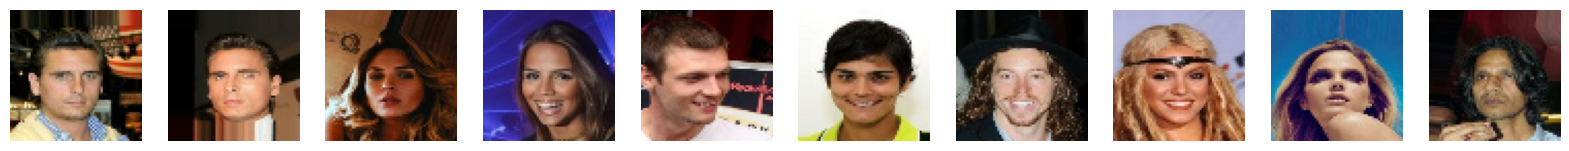

Reconstructions


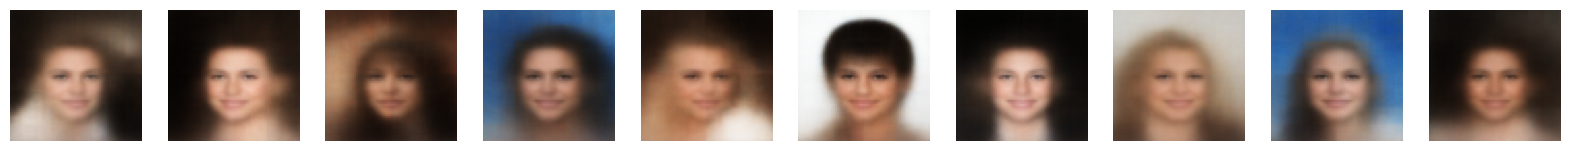

In [18]:
#create autoencoder predictions and display 

z_mean, z_log_var , reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

### Latent space distribution 

4/4 [==============================] - 0s 2ms/step


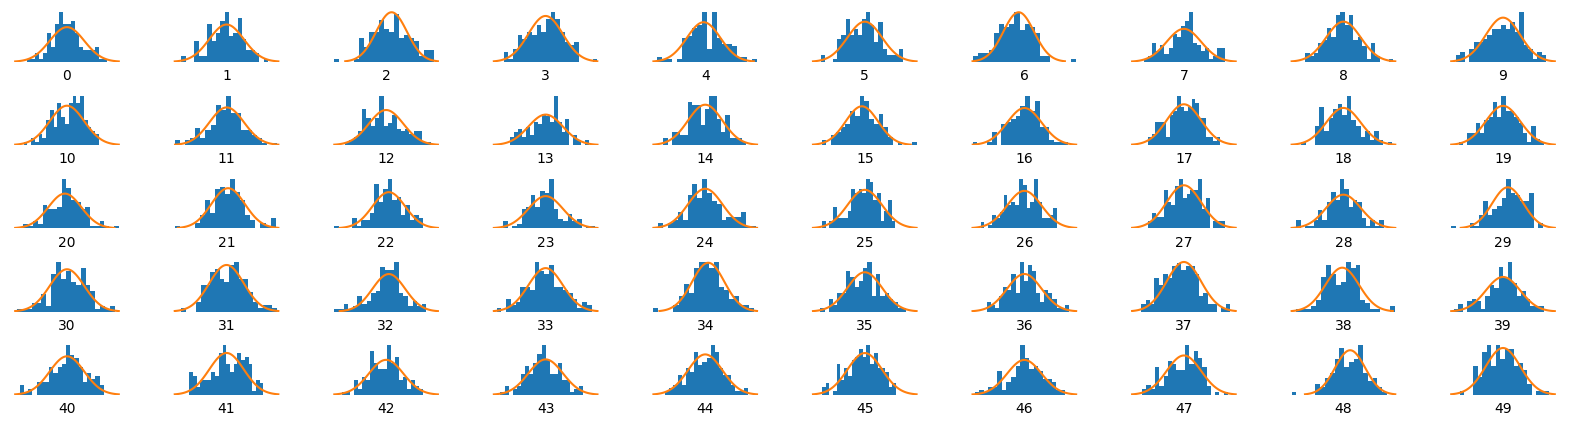

In [19]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

### Generate new faces

In [20]:
#Sample some points in the latent space, from the standard normal distribution 
grid_width, grid_height = (10,3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [21]:
#Decode the sampled points 
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 231ms/step


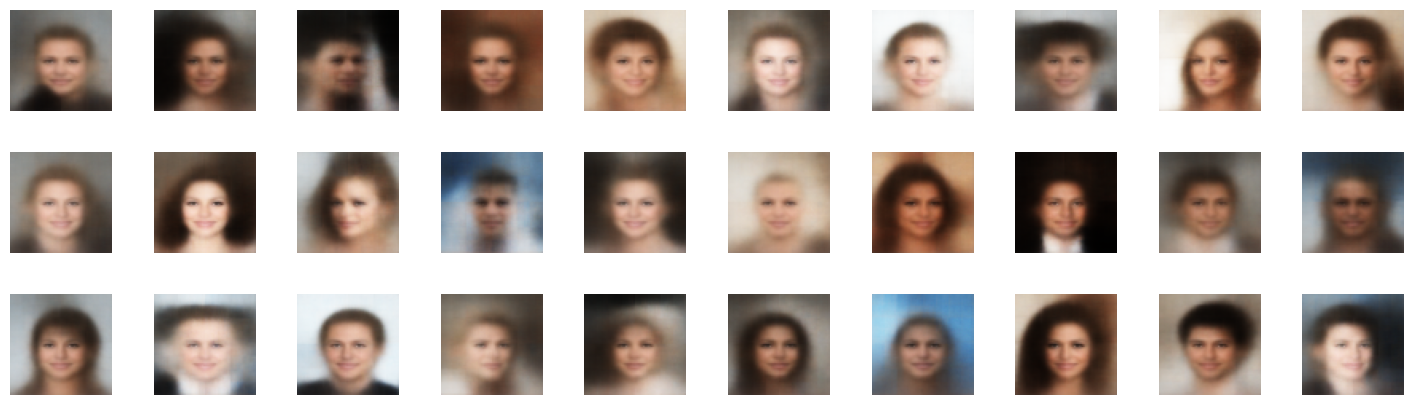

In [22]:
#Draw a plot of decoded images
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

### Manipulate the images 


In [24]:
# Load the label dataset
attributes = pd.read_csv("../data/celeba-dataset/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [26]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "../data/celeba-dataset/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [27]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.087    : 1.295    : 3.386    : 3.386
44    : 2.131    : 0.87    : 2.536    : -0.85
65    : 1.194    : 0.553    : 2.179    : -0.357
87    : 0.864    : 0.406    : 2.002    : -0.177
110    : 0.701    : 0.307    : 1.903    : -0.099
128    : 0.5    : 0.266    : 1.862    : -0.041
150    : 0.482    : 0.218    : 1.867    : 0.005
171    : 0.413    : 0.18    : 1.792    : -0.074
197    : 0.356    : 0.16    : 1.721    : -0.071
218    : 0.289    : 0.165    : 1.706    : -0.015
241    : 0.298    : 0.134    : 1.68    : -0.026
260    : 0.252    : 0.124    : 1.662    : -0.019
282    : 0.236    : 0.107    : 1.637    : -0.024
302    : 0.223    : 0.098    : 1.615    : -0.023
317    : 0.168    : 0.095    : 1.606    : -0.009
337    : 0.18    : 0.082    : 1.616    : 0.01
356    : 0.182    : 0.083    : 1.604    : -0.012
377    : 0.185    : 0.075    : 1.577    : -0.026
395    : 0.141    : 0.073    : 1.56    : -0.017
415    : 0.158  

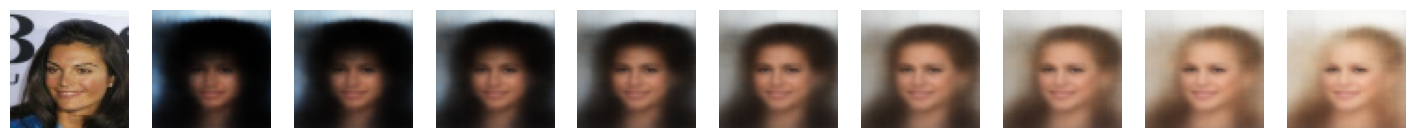

In [28]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)